# Illustrations of Pattern Recognition Letters 2019 article 

This notebook repoduces the illustrations of the jounral article:

> B. Perret and J. Cousty and S. J. F. Guimarães and Y. Kenmochi and L. Najman. 
> Removing non-significant regions in hierarchical clustering and segmentation. 
> Pattern Recognition Letters, 128, pp. 433-439, 2019. DOI: [10.1016/j.patrec.2019.10.008](https://doi.org/10.1016/j.patrec.2019.10.008)

In [1]:
%%capture
!pip install higra

In [2]:
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import higra as hg
import random

try:
    from utils import * # imshow, locate_resource
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

## Non-relevant node removale on graph hierarchical clustering

This demonstrates the use of small node removal in hierarchical clustering of simulated point clouds.

First a few utility functions to generates random 2d point clouds:

In [3]:
def random_point_cloud():
    if random.random() < 0.5:
        return point_cloud_varied(200, random.randrange(1000))
    else:
        return point_cloud_aniso(200, random.randrange(1000))

def point_cloud_varied(n_samples, state=None):
    from sklearn import datasets
    X, y = datasets.make_blobs(n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=state)
    return X, y

def point_cloud_aniso(n_samples, state=None):
    from sklearn import datasets
    X, y = datasets.make_blobs(n_samples, random_state=state)
    X    = np.dot(X, [[0.6, -0.6], [-0.4, 0.8]])
    return X, y

Generation of 3 random graphs, construction of their quasi flat zone hierarchies and filtering.

Image                  QFZ                    QFZ 3 class            QFZ filtered           QFZ filtered 3 class   


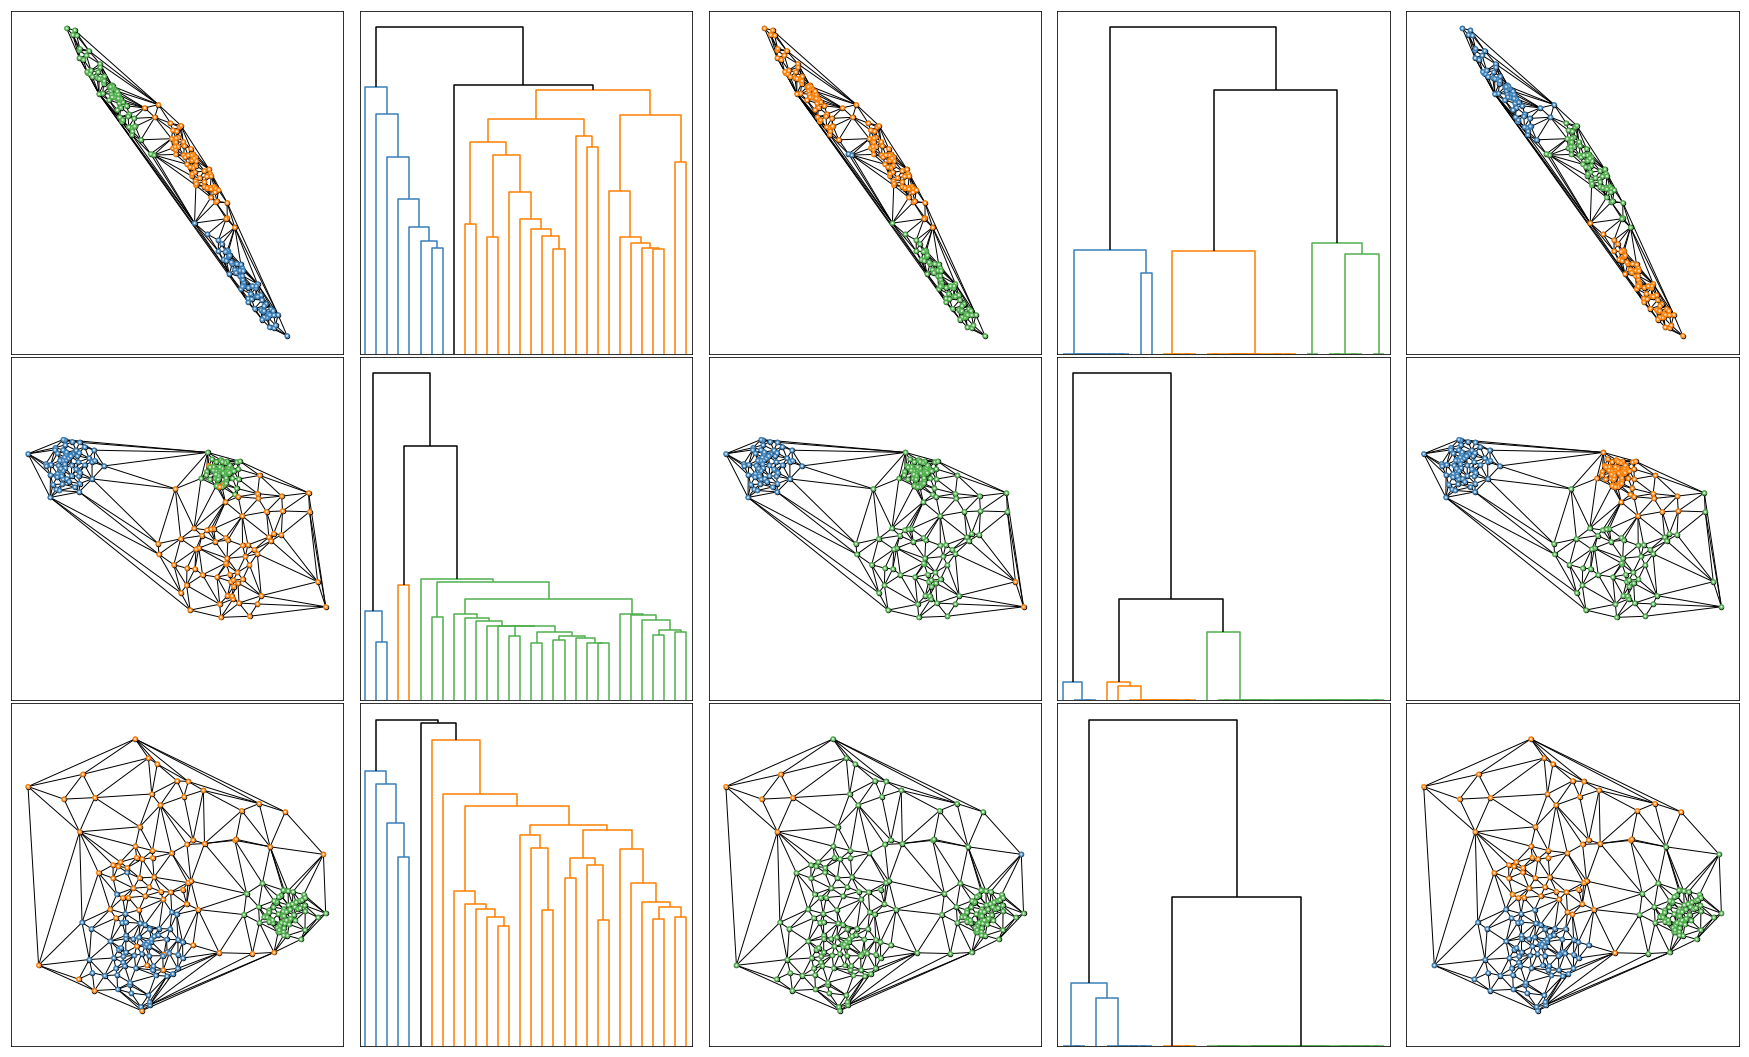

In [4]:
num_examples = 3

fig = plt.figure(figsize=(5 * 5, num_examples * 5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

def plot_im(y, x, im):
    plt.subplot(len(images), 5, y * 5 + x + 1); 
    plt.imshow(im, interpolation="bicubic", cmap="gray"); 
    plt.xticks([]); plt.yticks([])

print("{:23s}{:23s}{:23s}{:23s}{:23s}".format("Image", "QFZ", "QFZ 3 class", "QFZ filtered", "QFZ filtered 3 class") )

random.seed(33)
for i in range(num_examples):
    # get a random 2d point cloud composed of 3 clusters
    X, y = random_point_cloud()
    
    # build Delaunay graph of the point cloud
    graph, edge_weights = hg.make_graph_from_points(X, graph_type="delaunay")

    plt.subplot(num_examples, 5, i * 5 + 1);     
    hg.plot_graph(graph, vertex_positions=X, vertex_labels=y)
    
    # compute quasi-flat zone hierarchy
    tree, altitudes = hg.quasi_flat_zone_hierarchy(graph, edge_weights)
    plt.subplot(num_examples, 5, i * 5 + 2);    
    hg.plot_partition_tree(tree, altitudes=altitudes, n_clusters=3)
    
    # extract the 3 class partition from quasi-flat zone hierarchy
    labels = hg.labelisation_horizontal_cut_from_num_regions(tree, altitudes, 3)
    plt.subplot(num_examples, 5, i * 5 + 3);  
    hg.plot_graph(graph, vertex_positions=X, vertex_labels=labels)

    # remove small clusters from quasi-flat zone hierarchy
    tree_filtered, altitudes_filtered = hg.filter_small_nodes_from_tree(tree, altitudes, 10)
    plt.subplot(num_examples, 5, i * 5 + 4);  
    hg.plot_partition_tree(tree_filtered, altitudes=altitudes_filtered, n_clusters=3)
    
    # extract the 3 class partition from teh filtered quasi-flat zone hierarchy
    labels = hg.labelisation_horizontal_cut_from_num_regions(tree_filtered, altitudes_filtered, 3)
    plt.subplot(num_examples, 5, i * 5 + 5);
    hg.plot_graph(graph, vertex_positions=X, vertex_labels=labels)

## Non-relevant node removale on image hierarchical segmentation

This demonstrates the use of non-relevant node removal in hierarchical segmentation of natural images. 
Two cases are illustrated:

1. quasi-flat zone hierarchy versus quasi-flat zone hierarchy with small nodes removed; and
2. watershed hierarchy by area versus watershed hierarchy by area with weak frontiers removed.

First some utility functions to plot an image and to compute a gradient graph from an image:

In [5]:
def plot_im(y, x, im):
    plt.subplot(len(images), 5, y * 5 + x + 1); 
    plt.imshow(im, interpolation="bicubic", cmap="gray"); 
    plt.xticks([]); plt.yticks([])

# SED detector
detector = None
    
def build_graph_from_image(image):
    global detector
    if detector is None:
        import cv2
        detector = cv2.ximgproc.createStructuredEdgeDetection(get_sed_model_file())
        
    # switch to float to avoir numerical issue with uint8
    image = image.astype(np.float32)/255 
    # discard the color channel
    size = image.shape[:2]
    gradient_image = detector.detectEdges(image)
    gradient_image /= np.max(gradient_image)
    graph = hg.get_4_adjacency_graph(size)
    
    # we take a mix of SED gradient and RGB gradient
    edge_weights1 = hg.weight_graph(graph, image, hg.WeightFunction.L2)
    edge_weights2 = hg.weight_graph(graph, gradient_image, hg.WeightFunction.mean)
    
    edge_weights = edge_weights2 * 0.8 + edge_weights1 * 0.2
    
    return graph, edge_weights

Process a set of images:

Image                  QFZ                    QFZ Filtered           WS-Area                WS-Area Filtered       


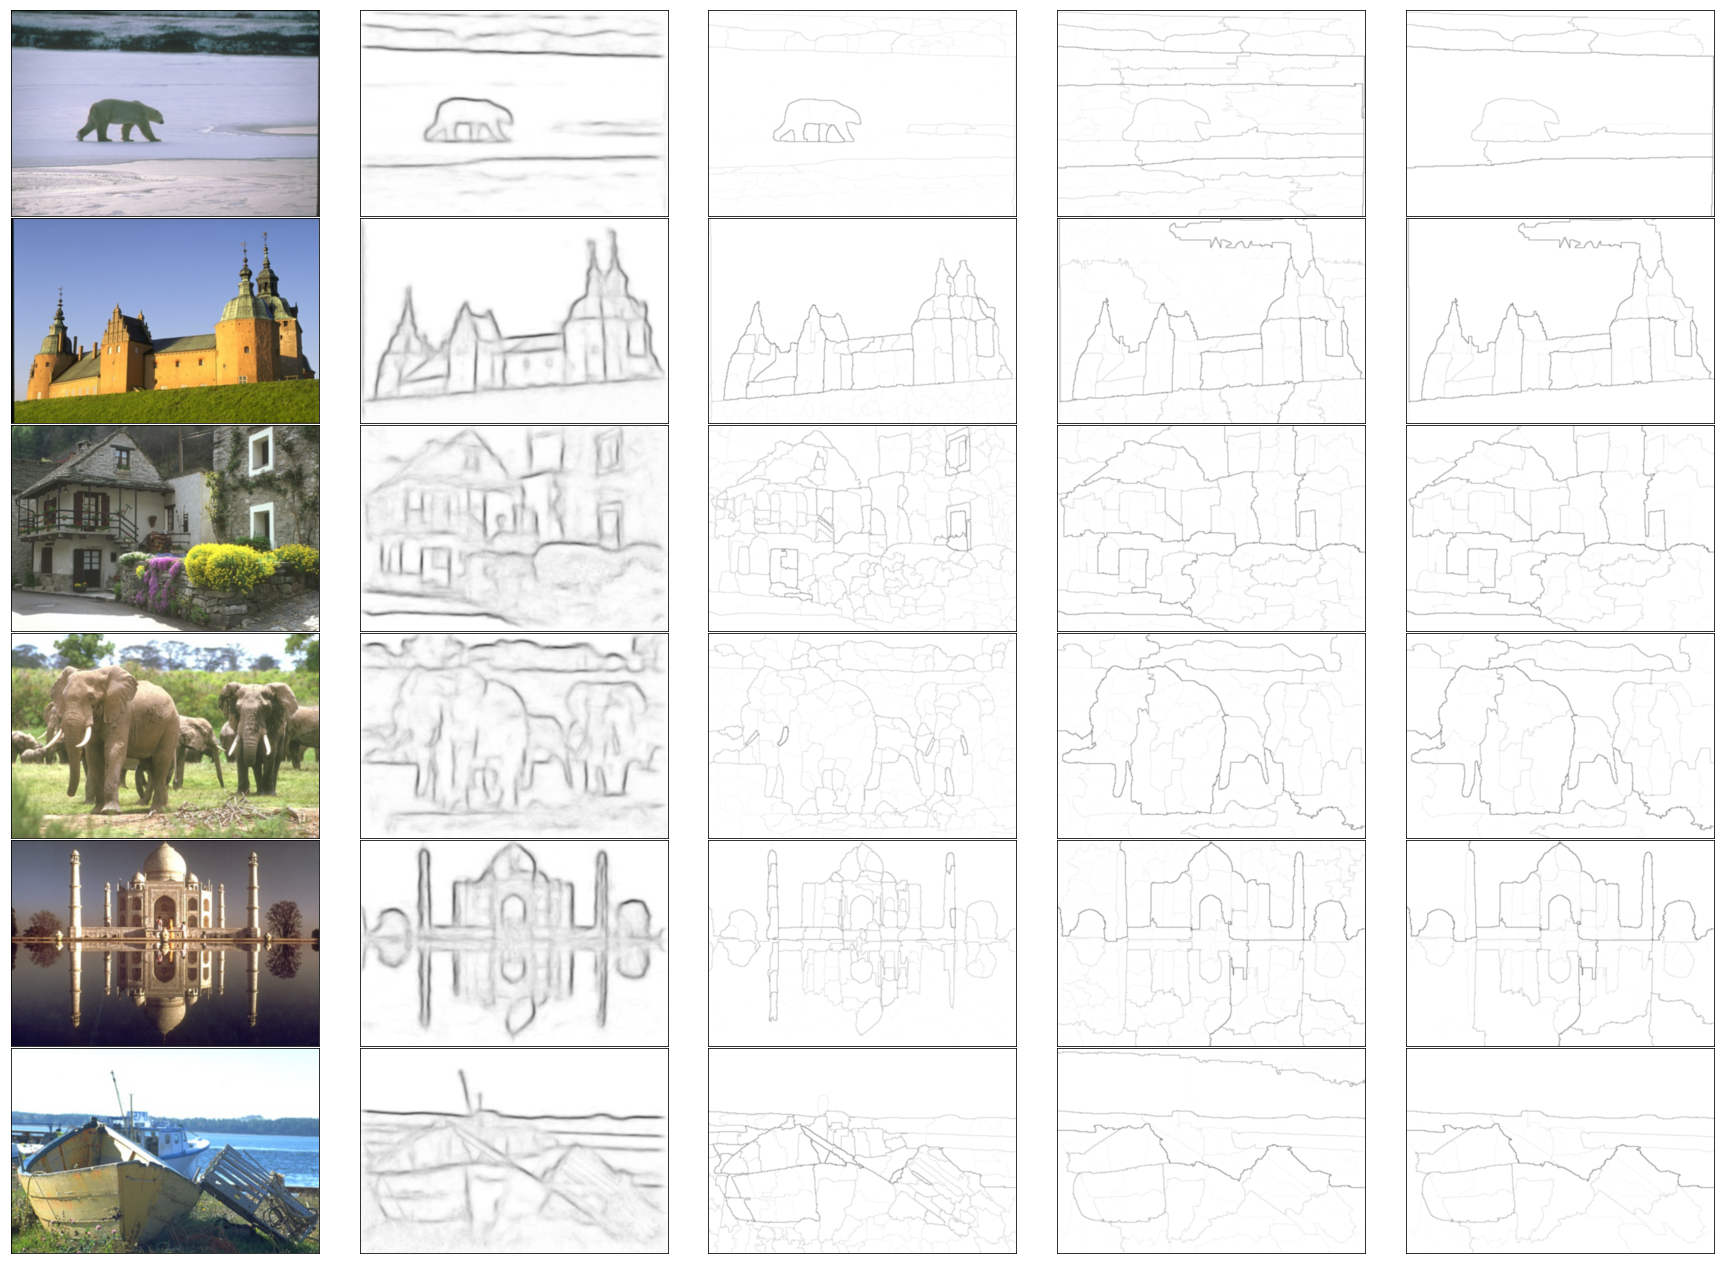

In [6]:
images = ["100007", "201080", "207038", "253016", "288024", "393035"]

fig = plt.figure(figsize=(5 * 5, len(images) * 3))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

print("{:23s}{:23s}{:23s}{:23s}{:23s}".format("Image", "QFZ", "QFZ Filtered", "WS-Area", "WS-Area Filtered") )

for i, im in enumerate(images):
    image = imageio.imread(locate_resource(im +".jpg"))
    plot_im(i, 0, image)
    
    # construct edge weighted graph from image
    graph, edge_weights = build_graph_from_image(image)
   
    # compute quasi-flat zone hierarchy
    tree, altitudes = hg.quasi_flat_zone_hierarchy(graph, edge_weights)
    # compute saliency map
    saliency =  hg.saliency(tree, altitudes)
    # draw saliency map in Khalimsky space and adjust contrast
    saliency_khalimsky = hg.graph_4_adjacency_2_khalimsky(graph, saliency)
    saliency_khalimsky = (1 - saliency_khalimsky / np.max(saliency_khalimsky))
    plot_im(i, 1, saliency_khalimsky)
    
    # removal of small nodes from the quasi-flat zone hierarchy
    tree, altitudes = hg.filter_small_nodes_from_tree(tree, altitudes, 100)
    saliency =  hg.saliency(tree, altitudes)
    saliency_khalimsky =hg.graph_4_adjacency_2_khalimsky(graph, saliency)
    saliency_khalimsky = (1 - saliency_khalimsky / np.max(saliency_khalimsky))
    plot_im(i, 2, saliency_khalimsky)    

    # compute watershed hierarchy by area
    tree, altitudes = hg.watershed_hierarchy_by_area(graph, edge_weights)
    saliency =  hg.saliency(tree, altitudes)
    saliency_khalimsky = hg.graph_4_adjacency_2_khalimsky(graph, saliency)
    saliency_khalimsky = (1 - saliency_khalimsky / np.max(saliency_khalimsky)) ** 5
    plot_im(i, 3, saliency_khalimsky)    
    
    # removal of weak frontier from the watershed hierarchy by area
    tree, altitudes = hg.filter_weak_frontier_nodes_from_tree(tree, altitudes, edge_weights, 0.1)
    saliency =  hg.saliency(tree, altitudes) 
    saliency_khalimsky = hg.graph_4_adjacency_2_khalimsky(graph, saliency)
    saliency_khalimsky = (1 - saliency_khalimsky / np.max(saliency_khalimsky)) ** 5
    plot_im(i, 4, saliency_khalimsky)